<a href="https://colab.research.google.com/github/aditya161205/NLP/blob/main/hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import pipeline
import pandas as pd

In [2]:
clf=pipeline('text-classification')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [3]:
text="i dont know how to operate hugging face "

output=clf(text)

output

[{'label': 'NEGATIVE', 'score': 0.9972416162490845}]

In [4]:
bot = pipeline("question-answering")

question="what do i dont know about hugging face?"

outputs=bot(question=question,context=text)

pd.DataFrame([outputs])

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Device set to use cuda:0


,score,start,end,answer
0,0.590968,12,39,how to operate hugging face


In [5]:
text="Tokenization is easier on hugging face library"

tokenized=list(text)
print(tokenized)


['T', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n', ' ', 'i', 's', ' ', 'e', 'a', 's', 'i', 'e', 'r', ' ', 'o', 'n', ' ', 'h', 'u', 'g', 'g', 'i', 'n', 'g', ' ', 'f', 'a', 'c', 'e', ' ', 'l', 'i', 'b', 'r', 'a', 'r', 'y']


In [6]:
token2id={ch:idx for idx,ch in enumerate(sorted(set(tokenized)))}
print(token2id)


{' ': 0, 'T': 1, 'a': 2, 'b': 3, 'c': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'k': 10, 'l': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'u': 17, 'y': 18, 'z': 19}


In [7]:
input_id=[token2id[token] for token in tokenized]
print(input_id)

[1, 13, 10, 5, 12, 9, 19, 2, 16, 9, 13, 12, 0, 9, 15, 0, 5, 2, 15, 9, 5, 14, 0, 13, 12, 0, 8, 17, 7, 7, 9, 12, 7, 0, 6, 2, 4, 5, 0, 11, 9, 3, 14, 2, 14, 18]


In [8]:
categorical_df=pd.DataFrame({"Name":["mumbai","Delhi","paris"], "labels":[0,1,2]})
print(categorical_df)

     Name  labels
0  mumbai       0
1   Delhi       1
2   paris       2


In [9]:
pd.get_dummies(categorical_df['Name'])

,Delhi,mumbai,paris
0,False,True,False
1,True,False,False
2,False,False,True


In [10]:
import torch


In [11]:

input_id=torch.tensor(input_id)

one_hot_id=torch.nn.functional.one_hot(input_id,num_classes=len(token2id))
print(one_hot_id.size())

torch.Size([46, 20])


In [12]:
print("token:", tokenized[0])
print("token id:", input_id[0])
print("one hot:", one_hot_id[0])


token: T
token id: tensor(1)
one hot: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [13]:
from transformers import AutoTokenizer

model_ckpt="distilbert-base-uncased"

tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
encoded_text=tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 3989, 2003, 6082, 2006, 17662, 2227, 3075, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##ization',
 'is',
 'easier',
 'on',
 'hugging',
 'face',
 'library',
 '[SEP]']

In [16]:
sentence=tokenizer.convert_tokens_to_string(tokens)
sentence[6:-6]

'tokenization is easier on hugging face library'

In [17]:
def tokenize(batch):
 return tokenizer(batch["text"], padding=True, truncation=True)

In [18]:
from transformers import AutoModel

In [19]:
model_ckpt='distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model=AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [21]:
text="we are learing to use pretrained models"

inputs=tokenizer(text,return_tensors='pt')

inputs['input_ids'].size()

torch.Size([1, 12])

In [22]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
 outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.0434, -0.0720,  0.0993,  ..., -0.1783,  0.3892,  0.2642],
         [ 0.1712, -0.1591, -0.0926,  ..., -0.1383,  1.0626, -0.4853],
         [ 0.0510,  0.0687,  0.0340,  ..., -0.2585,  0.3928,  0.2018],
         ...,
         [-0.1951, -0.5184,  0.3793,  ..., -0.5062,  0.1910, -0.1710],
         [ 0.0784, -0.0778,  0.1604,  ..., -0.3404, -0.1370,  0.0460],
         [ 0.8096,  0.2678, -0.2260,  ...,  0.1065, -0.5542, -0.3010]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [23]:
outputs.last_hidden_state.size()

torch.Size([1, 12, 768])

In [24]:
def extract_hidden_states(batch):
 # Place model inputs on the GPU
 inputs = {k:v.to(device) for k,v in batch.items()if k in tokenizer.model_input_names}
 # Extract last hidden states
 with torch.no_grad():
  last_hidden_state = model(**inputs).last_hidden_state
 # Return vector for [CLS] token
 return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [25]:
from datasets import load_dataset

emotions = load_dataset('emotion')

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [27]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])


In [28]:
emotions_hidden_state=emotions_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [29]:
emotions_hidden_state["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
import numpy as np

In [31]:
X_train = np.array(emotions_hidden_state["train"]["hidden_state"])
X_valid = np.array(emotions_hidden_state["validation"]["hidden_state"])
y_train = np.array(emotions_hidden_state["train"]["label"])
y_valid = np.array(emotions_hidden_state["validation"]["label"])
X_train.shape, X_valid.shape
((16000, 768), (2000, 768))

((16000, 768), (2000, 768))

In [32]:
import matplotlib.pyplot as plt


In [33]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.285322,3.581167,0
1,-3.131538,4.555245,0
2,5.469858,6.961502,3
3,-2.306453,6.514164,2
4,-3.249187,6.572284,3


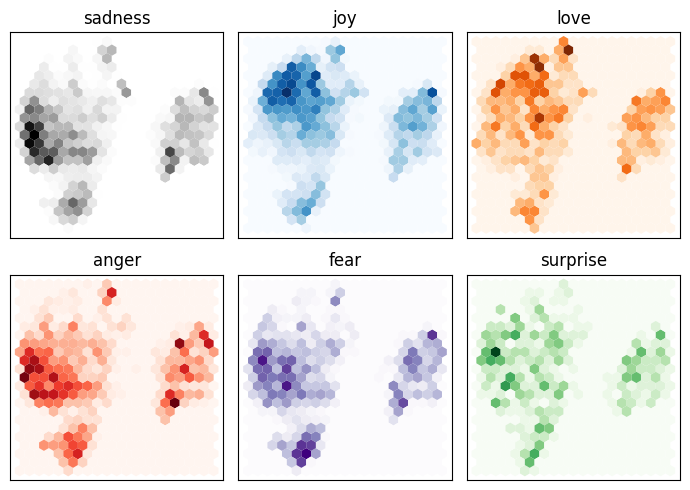

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
 df_emb_sub = df_emb.query(f"label == {i}")
 axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
 gridsize=20, linewidths=(0,))
 axes[i].set_title(label)
 axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [35]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

In [36]:
from transformers import AutoModelForSequenceClassification

In [37]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)


0.352

In [38]:
from transformers import AutoModelForSequenceClassification

num_labels=6
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining performance metrics

In [39]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [40]:
from huggingface_hub import notebook_login
notebook_login()

In [41]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
 num_train_epochs=2,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
eval_strategy="epoch",
 disable_tqdm=False,
 logging_steps=logging_steps,
 push_to_hub=True,
log_level="error")

In [43]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=emotions_encoded["train"], eval_dataset=emotions_encoded["validation"], tokenizer=tokenizer)
trainer.train()

/tmp/ipython-input-3758627479.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics, train_dataset=emotions_encoded["train"], eval_dataset=emotions_encoded["validation"], tokenizer=tokenizer)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pathakaditya161205 (pathakaditya161205-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.811400,0.304580,0.908000,0.907777
2,0.243100,0.215610,0.921500,0.921366


TrainOutput(global_step=500, training_loss=0.5272684326171875, metrics={'train_runtime': 284.7126, 'train_samples_per_second': 112.394, 'train_steps_per_second': 1.756, 'total_flos': 720342861696000.0, 'train_loss': 0.5272684326171875, 'epoch': 2.0})

In [44]:
trainer.push_to_hub(commit_message="Training completed!")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...finetuned-emotion/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...finetuned-emotion/model.safetensors:  13%|#2        | 33.5MB /  268MB            

  ...vents.1758439563.54477df24408.210.0: 100%|##########| 6.69kB / 6.69kB            

CommitInfo(commit_url='https://huggingface.co/Aditya161205/distilbert-base-uncased-finetuned-emotion/commit/b2f4c6f7e1637f423b975eb4b61a180d95333ea1', commit_message='Training completed!', commit_description='', oid='b2f4c6f7e1637f423b975eb4b61a180d95333ea1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Aditya161205/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='Aditya161205/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [45]:
from transformers import pipeline
model_id= "Aditya161205/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [46]:
custom= "i didnt expected this from the movie"
preds= classifier(custom, return_all_scores=True)
preds

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.1331862360239029},
  {'label': 'LABEL_1', 'score': 0.5776056051254272},
  {'label': 'LABEL_2', 'score': 0.05685408413410187},
  {'label': 'LABEL_3', 'score': 0.08497479557991028},
  {'label': 'LABEL_4', 'score': 0.11685147136449814},
  {'label': 'LABEL_5', 'score': 0.030527815222740173}]]

In [47]:
import matplotlib.pyplot as plt

In [48]:
df=pd.DataFrame(preds[0])
df['label'] = df['label'].apply(lambda x: labels[int(x.split('_')[1])])
df

,label,score
0,sadness,0.133186
1,joy,0.577606
2,love,0.056854
3,anger,0.084975
4,fear,0.116851
5,surprise,0.030528


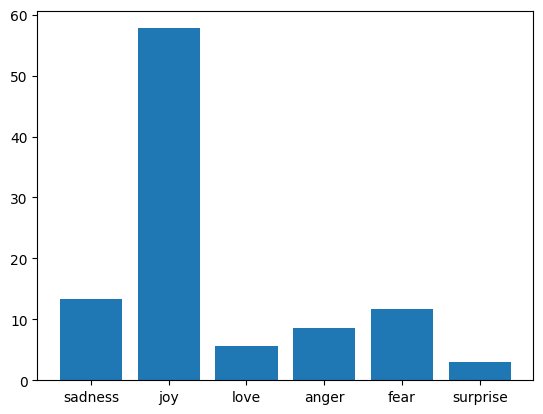

In [49]:
df=pd.DataFrame(preds[0])
plt.bar(labels,100*df["score"])
plt.show()